In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics.pairwise import cosine_similarity


# Latent matrix from metadata

In [5]:
df = pd.read_csv('data/2019_oct_sort_1000.csv')

In [6]:
df.shape

(1000, 9)

In [7]:
df.columns

Index(['event_time', 'event_type', 'product_id', 'category_id',
       'category_code', 'brand', 'price', 'user_id', 'user_session'],
      dtype='object')

In [8]:
df.head()

,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session
0,2019-10-18 10:54:45 UTC,view,54900011,2146660887203676486,apparel.costume,NaN,64.35,515483062,00000042-3e3f-42f9-810d-f3d264139c50
1,2019-10-18 10:55:20 UTC,view,54900011,2146660887203676486,apparel.costume,NaN,64.35,515483062,00000042-3e3f-42f9-810d-f3d264139c50
2,2019-10-31 06:25:30 UTC,view,1005105,2053013555631882655,electronics.smartphone,apple,1349.46,513782162,00000056-a206-40dd-b174-a072550fa38c
3,2019-10-31 06:25:52 UTC,view,5100816,2053013553375346967,NaN,xiaomi,29.60,513782162,00000056-a206-40dd-b174-a072550fa38c
4,2019-10-31 06:23:12 UTC,view,1005115,2053013555631882655,electronics.smartphone,apple,955.84,513782162,00000056-a206-40dd-b174-a072550fa38c


In [9]:
def preprocessing_feat(X, drop_event_time=False):
    if drop_event_time:
        X = X.drop("event_time", axis=1)
    
    X_preprocessed = X.dropna(subset = ['category_code', 'brand']) #tbd!!
    X_preprocessed = X_preprocessed.drop_duplicates()
    X_preprocessed['category_code'] = X_preprocessed['category_code'].str.replace('.',' ')
    return X_preprocessed

In [10]:
X_preprocessed = preprocessing_feat(df,  drop_event_time=True)

/tmp/ipykernel_827/4055017079.py:7: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  X_preprocessed['category_code'] = X_preprocessed['category_code'].str.replace('.',' ')


In [11]:
X_preprocessed.shape

(445, 8)

## Pricing criterion

In [12]:
def make_column(row):
    if row["price"] < row["25%"]:
        return "low"
    elif row["price"] < row["75%"]:
        return "medium"
    else:
        return "high"

def pricing_criterion(X):
    pricing_guide = X.groupby('category_code')['price'].describe()[["25%", "75%"]].reset_index()
    X_merged = X.merge(pricing_guide, on="category_code", how="right")
    X_merged["price_category"] = X_merged.apply(lambda row: make_column(row), axis=1)
    return X_merged


In [13]:
X_merged = pricing_criterion(X_preprocessed)

In [14]:
def metadata(X):
    X['metadata'] = X[['category_code', 'brand', 'price_category']].apply(lambda x: ' '.join(x), axis = 1)
    return X


In [15]:
X_meta = metadata(X_merged)

In [16]:
X_meta.set_index(X_meta['product_id'], inplace=True)

In [17]:
print(X_meta.shape)
X_meta.head()

(445, 12)


,event_type,product_id,category_id,category_code,brand,price,user_id,user_session,25%,75%,price_category,metadata
product_id,,,,,,,,,,,,
49800017,view,49800017,2126679654801604876,accessories bag,ritmix,12.32,537956308,00003599-a772-4c8a-9c22-0dfa4f6ecc83,13.8750,41.0500,low,accessories bag ritmix low
49800020,view,49800020,2126679654801604876,accessories bag,ritmix,15.43,537956308,00003599-a772-4c8a-9c22-0dfa4f6ecc83,13.8750,41.0500,medium,accessories bag ritmix medium
28401080,view,28401080,2053013566209917945,accessories bag,respect,66.67,516007189,000037a4-c043-4113-9b53-7bbb5d7c2bfe,13.8750,41.0500,high,accessories bag respect high
28719157,view,28719157,2116907519078040377,apparel shoes,salamander,127.42,532234792,00006cdc-ee07-41db-958a-232b53a1f4fd,72.5875,88.4875,high,apparel shoes salamander high
28717170,view,28717170,2053013565639492569,apparel shoes,respect,84.43,557816044,000097b7-14fd-4336-a0e6-c82c981f8817,72.5875,88.4875,medium,apparel shoes respect medium


### Count Vectorizer

In [18]:
count = CountVectorizer()
count_matrix = count.fit_transform(X_meta['metadata'])
count_df_1 = pd.DataFrame(count_matrix.toarray(), index=X_meta.product_id.tolist())
print(count_df_1.shape)
count_df_1.head()

(445, 170)


,0,1,2,3,4,5,6,7,8,9,...,160,161,162,163,164,165,166,167,168,169
49800017,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
49800020,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
28401080,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
28719157,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
28717170,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [19]:
count_df_1 = count_df_1.reset_index()

In [20]:
len(list(set(count_df_1.index)))#.nunique()

445

In [21]:
count_df_1.drop_duplicates(subset='index', keep='first', inplace=True) 
count_df_1["product_id"] = count_df_1["index"]
count_df_1.drop("index", axis=1, inplace=True)
count_df_1.head()

,0,1,2,3,4,5,6,7,8,9,...,161,162,163,164,165,166,167,168,169,product_id
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,49800017
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,49800020
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,28401080
3,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,28719157
4,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,28717170


### Dimensionality reduction

In [22]:
n = 50
svd = TruncatedSVD(n_components=n)
latent_df_1 = svd.fit_transform(count_df_1.set_index("product_id"))

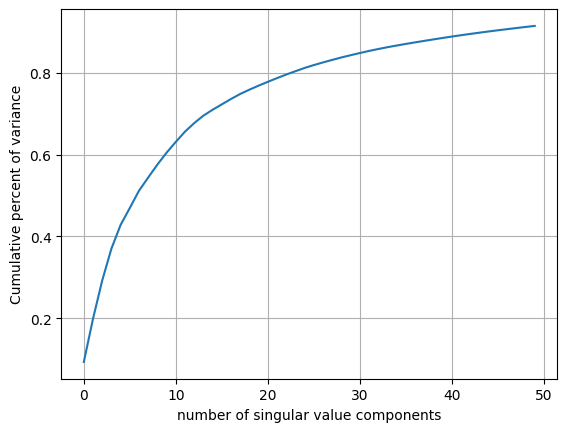

In [23]:
plt.plot(svd.explained_variance_ratio_.cumsum())
plt.xlabel('number of singular value components')
plt.ylabel('Cumulative percent of variance')   
plt.grid()
plt.show()

In [24]:
#count_df_1=count_df_1.set_index("product_id")
#count_df_1.head()
df_for_latent1 = count_df_1.product_id.tolist()

In [25]:
#n defined above
#n = 50
latent_df_1 = pd.DataFrame(latent_df_1[:,0:n], index=df_for_latent1)
print(latent_df_1.shape)
latent_df_1

(310, 50)


,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
49800017,0.159126,0.094781,0.074467,0.867845,0.104342,0.451602,0.152625,-0.047068,0.053521,0.675642,...,-0.053951,-0.008059,-0.007596,-0.023509,-0.023977,-0.056112,-0.002533,-0.001694,-0.003482,-0.004963
49800020,0.409155,-0.382170,0.576855,-0.308769,0.238508,0.484030,0.073801,0.038980,0.071821,0.701121,...,-0.064123,0.026500,-0.007285,-0.016543,-0.021770,-0.054556,-0.002269,-0.002368,-0.004375,-0.003803
28401080,0.265688,0.819887,-0.069625,-0.261478,0.272532,0.385874,0.291194,0.005876,0.199421,0.596432,...,0.028204,-0.034326,0.003579,-0.009391,-0.006769,-0.012918,-0.001677,-0.002969,-0.010594,-0.011034
28719157,0.274873,0.828929,-0.039082,-0.235706,0.326835,0.626002,0.366783,0.021173,0.926960,-0.465166,...,-0.038027,0.033783,0.005192,-0.022045,-0.025234,-0.012966,-0.003661,-0.009005,-0.008866,-0.007281
28717170,0.424708,-0.360599,0.624793,-0.291207,0.327407,0.838738,0.194364,0.061150,1.015400,-0.473332,...,0.070423,-0.034485,-0.002702,0.021888,0.024179,0.025483,0.003596,0.006873,0.010001,0.009126
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8901444,0.405871,-0.403868,0.573468,-0.335038,0.207657,0.363650,0.009501,0.043420,0.016501,0.069495,...,0.011119,-0.002075,-0.007650,0.014397,0.018716,-0.008288,0.014688,0.050022,-0.082879,0.025267
10400294,0.156276,0.073684,0.071730,0.851527,0.074652,0.338353,0.090313,-0.043913,-0.001854,0.045490,...,0.033802,-0.060826,-0.013156,0.012127,0.029148,-0.012848,0.027588,0.114067,-0.160586,0.039074
10400334,0.406306,-0.403267,0.574117,-0.325087,0.208818,0.370782,0.011488,0.042135,0.016445,0.070969,...,0.023629,-0.026266,-0.012845,0.019093,0.031354,-0.011293,0.027852,0.113393,-0.161479,0.040235
10400398,0.259958,0.803929,-0.085135,-0.281876,0.228669,0.213571,0.211477,0.002942,0.025685,0.052357,...,-0.021689,0.016624,0.000330,-0.035633,-0.040788,-0.016026,-0.057902,-0.266976,0.498782,0.011576


In [26]:
latent_df_1.reset_index().drop_duplicates().shape

(310, 51)

In [27]:
#X_meta['product_id'].nunique()

# Latent matrix from event types

In [28]:
def preprocessing_event(X):
    X_preprocessed = X.dropna(subset = ['category_code', 'brand']) #tbd!!
    X_preprocessed = X_preprocessed.drop_duplicates()
    return X_preprocessed

In [29]:
df_event = preprocessing_event(df)

In [59]:
dct = {'view': 1, 'cart': 3, 'purchase': 5, 'remove_from_cart': -1}

In [60]:
df_event['rating'] = df_event['event_type'].map(dct)

In [61]:
df_event["rating"].sum()

743

In [62]:
df_rating.shape

(310, 186)

In [63]:
df_rating = df_event.pivot_table(values='rating',
                                 index='product_id',
                                 columns='user_id',
                                 aggfunc="sum").fillna(0)
df_rating

user_id,512483064,512561891,512600925,512625864,512652590,512843699,512845701,512893095,513035269,513160929,...,563123464,563195675,563543861,563842008,564098956,564240719,564555327,564879838,565847508,566031240
product_id,,,,,,,,,,,,,,,,,,,,,
1002532,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1002540,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1002542,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1002544,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1002633,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35200189,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
43300127,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
45300048,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [64]:
df_rating.sum().reset_index()[0].sum()

743.0

In [65]:
df_event.groupby("user_id").agg({"rating":sum}).sort_values(by="rating").sum()

rating    743
dtype: int64

In [66]:
df_rating.reset_index()

user_id,product_id,512483064,512561891,512600925,512625864,512652590,512843699,512845701,512893095,513035269,...,563123464,563195675,563543861,563842008,564098956,564240719,564555327,564879838,565847508,566031240
0,1002532,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1002540,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1002542,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1002544,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1002633,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
305,35200189,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
306,43300127,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
307,45300048,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
308,49800017,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [67]:
svd = TruncatedSVD(n_components=75)
latent_df_2 = svd.fit_transform(df_rating)

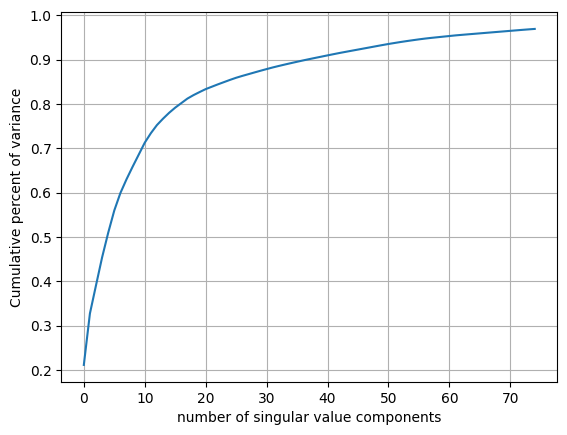

In [68]:
plt.plot(svd.explained_variance_ratio_.cumsum())
plt.xlabel('number of singular value components')
plt.ylabel('Cumulative percent of variance')   
plt.grid()
plt.show()

In [69]:
latent_df_2 = pd.DataFrame(latent_df_2, index=df_rating.reset_index().product_id.tolist())
latent_df_2.head()

,0,1,2,3,4,5,6,7,8,9,...,65,66,67,68,69,70,71,72,73,74
1002532,-5.936426e-18,-2.553261e-18,7.538438e-16,-2.818916e-15,6.411416e-15,-1.318449e-14,-5.240119e-14,5.593616e-14,2.701317e-13,6.783737e-13,...,0.000086,0.000026,-0.000048,-0.000012,0.000084,-0.000132,0.000058,0.000167,-0.000303,-0.000104
1002540,-9.876461e-18,3.076271e-16,8.418257e-17,2.928067e-16,-3.313463e-15,2.779688e-15,7.515775e-15,5.622909e-14,-1.122941e-13,-1.490868e-13,...,-0.000008,-0.000002,0.000004,0.000001,-0.000007,0.000015,-0.000006,-0.000001,0.000025,0.000010
1002542,2.123614e-04,4.223970e-08,-2.676937e-14,2.715752e-14,-2.411964e-14,-5.249881e-06,-1.802384e-04,-3.229929e-06,2.416895e-12,-8.503042e-08,...,0.000003,-0.000591,0.000646,-0.000213,0.000933,0.001863,0.001025,-0.001516,0.005723,0.003020
1002544,5.367606e+00,-4.998541e-04,-3.236191e-14,-1.329703e-14,7.770416e-13,5.030703e-01,4.515955e+00,1.861108e-01,2.268154e-11,-6.335104e-03,...,-0.000134,0.000913,-0.002530,0.001191,-0.000024,0.000109,-0.004352,0.030782,-0.043026,-0.001938
1002633,7.973937e-02,8.646383e-06,-7.557310e-15,1.227753e-14,-9.558371e-14,-4.689849e-04,-1.237798e-02,-1.750773e-04,-6.535106e-13,-4.074839e-06,...,0.000004,-0.000237,0.000257,-0.000247,0.000751,0.000620,0.000119,-0.000748,0.004908,0.002431


In [70]:
latent_df_2.shape

(310, 75)

## Apply Cosine Similarity in Content and Collaborative Matrices


In [131]:
# Get the latent vectors for "Toy Story" from content and collaborative matrices
v1 = np.array(latent_df_1.loc[1002532]).reshape(1, -1)
v2 = np.array(latent_df_2.loc[1002532]).reshape(1, -1)

# Compute the cosine similarity of this movie with the others in the list
sim1 = cosine_similarity(latent_df_1, v1).reshape(-1)
sim2 = cosine_similarity(latent_df_2, v2).reshape(-1)

In [133]:
#'hybrid_similarity = (content_similarity + collaborative_similarity) / 2`

hybrid = ((sim1 + sim2)/2.0)


In [134]:
dictDf = {'features': sim1 , 'ratings': sim2, 'hybrid': hybrid} 
recommendation_df = pd.DataFrame(dictDf, index = latent_df_1.index)

In [135]:
recommendation_df.sort_values('features', ascending=False, inplace=True)
recommendation_df.head(10)

,features,ratings,hybrid
1002540,1.000000,-4.148228e-04,0.499793
1002542,1.000000,-9.072948e-08,0.500000
1003306,1.000000,-5.775508e-05,0.499971
1003141,1.000000,7.799060e-04,0.500390
1002544,1.000000,5.757946e-07,0.500000
1002633,1.000000,5.757946e-07,0.500000
1002532,1.000000,1.923320e-04,0.500096
1005069,0.868275,-9.072948e-08,0.434137
5100566,0.757363,-1.743947e-08,0.378681
5100343,0.757363,2.420445e-06,0.378683


In [126]:
recommendation_df.sort_values('ratings', ascending=False, inplace=True)
recommendation_df.head(10)

,features,ratings,hybrid
49800017,0.000046,1.000000,0.500023
49800020,0.251883,0.999999,0.625941
1701302,0.228637,0.002211,0.115424
3700479,-0.000602,0.001856,0.000627
1003535,0.750656,0.001762,0.376209
4804055,0.450916,0.001696,0.226306
4803943,0.234814,0.001696,0.118255
1004496,0.578290,0.001666,0.289978
1004835,0.750656,0.001575,0.376116
27000002,-0.000183,0.001573,0.000695


In [127]:
recommendation_df.sort_values('hybrid', ascending=False, inplace=True)
recommendation_df.head(10)

,features,ratings,hybrid
49800020,0.251883,9.999991e-01,0.625941
1003141,1.000000,7.799060e-04,0.500390
1002532,1.000000,1.923320e-04,0.500096
49800017,0.000046,1.000000e+00,0.500023
1002633,1.000000,5.757946e-07,0.500000
1002544,1.000000,5.757946e-07,0.500000
1002542,1.000000,-9.072948e-08,0.500000
1003306,1.000000,-5.775508e-05,0.499971
1002540,1.000000,-4.148228e-04,0.499793
1005069,0.868275,-9.072948e-08,0.434137
